In [1]:
# If you are in the Notebooks directory inside our project, no need run below line
!git clone https://github.com/ex3ploiter/DISTIL/

Cloning into 'DISTIL'...
remote: Enumerating objects: 790, done.
remote: Counting objects: 100% (302/302), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 790 (delta 200), reused 179 (delta 96), pack-reused 488 (from 1)
Receiving objects: 100% (790/790), 3.52 MiB | 25.92 MiB/s, done.
Resolving deltas: 100% (485/485), done.


In [2]:
# You should be in Notebooks directory after running below line
%cd "./DISTIL/DISTIL/Notebooks"

/kaggle/working/DISTIL/DISTIL/Notebooks


## Introduction
This notebook demonstrates a diffusion-based approach to mitigating backdoor attacks in neural networks. Backdoor attacks involve maliciously tampering with a neural network during training so that it behaves normally on most inputs but produces targeted misclassifications when specific trigger patterns are present in the input.

The DISTIL approach works by:
1. Identifying potential backdoor triggers using diffusion models
2. Generating synthetic trigger patterns using a novel trigger discovery algorithm
3. Fine-tuning the model on an augmented dataset that includes both clean images and generated trigger patterns


## Setup and Imports

In [3]:
import sys
sys.path.append('../../../')

In [4]:
!pip install git+https://github.com/openai/glide-text2im

  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-66hh57m_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/glide-text2im /tmp/pip-req-build-66hh57m_
  Resolved https://github.com/openai/glide-text2im to commit 69b530740eb6cef69442d6180579ef5ba9ef063e
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.6 MB/s eta 0:00:00
  Created wheel 

In [5]:
import warnings
warnings.filterwarnings('ignore')
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from tqdm import tqdm

# Import utility functions from your project
from DISTIL.DISTIL.utils.model_utils import (
    greedy_class_farthest,
    trigger_evaluation,
    plot_image_tensor)

from DISTIL.DISTIL.evaluation.asr import calculate_class0_percentage
from DISTIL.DISTIL.evaluation.test_accuracy import test_model
from DISTIL.DISTIL.models.load_models import get_transform
from DISTIL.DISTIL.models.diffusion_model_upsample import run_diffusion_with_trigger
from DISTIL.DISTIL.utils.model_utils import get_images_and_labels_by_label, greedy_class_farthest
from DISTIL.DISTIL.data_loader import model_loader, backbench
from DISTIL.DISTIL.mitigation.backdoor_mitigation import generate_augmented_dataset, AugmentedDataset \
    , prepare_classifier_for_mitigation, fine_tune_classifier, evaluate_mitigated_model \
    , mitigate_backdoor_model


In [6]:
# Global output file for logging results
OUTPUT_FILE = "./backdoored_models_mitigation_result"

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Run the pipeline

Download the model

In [7]:
%cd ..
!mkdir data
%cd data

import os
import gdown
import zipfile

# Google Drive file ID
file_id = "1zs6dgdvt0gjiI3GlRkmIknbtnfobCikH"

/kaggle/working/DISTIL/DISTIL
/kaggle/working/DISTIL/DISTIL/data


In [8]:
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
print("Downloading the file...")
file_name=gdown.download(url, quiet=False)


# Create a folder with the same name (without .zip)
folder_name = os.path.join('./vit_cifar10',file_name.replace('.zip',''))
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Extract the zip file
print("Extracting the file...")
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(folder_name)

# Remove the zip file (optional)
os.remove(file_name)

print(f"File downloaded and extracted to '{folder_name}' successfully!")

%cd ..
%cd Notebooks

Downloading...
From (original): https://drive.google.com/uc?id=1zs6dgdvt0gjiI3GlRkmIknbtnfobCikH
From (redirected): https://drive.google.com/uc?id=1zs6dgdvt0gjiI3GlRkmIknbtnfobCikH&confirm=t&uuid=25678c5e-bb45-4ece-9a8a-b41d7a63cca4
To: /kaggle/working/DISTIL/DISTIL/data/cifar10_vit_b_16_trojannn_0_1.zip
100%|██████████| 356M/356M [00:01<00:00, 255MB/s]


Extracting the file...
File downloaded and extracted to './vit_cifar10/cifar10_vit_b_16_trojannn_0_1' successfully!
/kaggle/working/DISTIL/DISTIL
/kaggle/working/DISTIL/DISTIL/Notebooks


## Mitigation

We calculate a score for each class (as the target class) and a source class (we use a heuristic to select this source class; for more info, check our paper. After calculating the score, we predict the class that has the highest corresponding score as the attack target class. After predicting the target class, we generate a trigger for each sample of a small set of test set that we have access to. Then we create a dataset (named augmented dataset) from the small test set samples and those samples with a generated trigger for the predicted target class, using the original label for the sample. We use the augmented dataset to fine-tune the backdoored model. Accuracy and ASR (Attack Success Rate) of the model are printed, before and after fine-tuning.
\
In this notebook, we only plot the first 4 classes to avoid a long output. The generated trigger shows the probability that the generated trigger is related to the target class.

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 214MB/s]


100%|██████████| 170M/170M [00:03<00:00, 48.7MB/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Selected model: cifar10_vit_b_16_trojannn_0_1
Model 0 loaded
Model name: cifar10_vit_b_16_trojannn_0_1
Examining 10 potential target classes


  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 0, Source class: 6


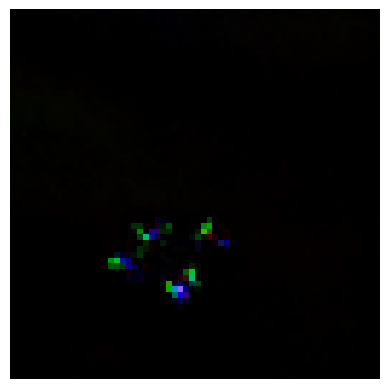

Trigger confidence: 0.9991366267204285


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 1, Source class: 0


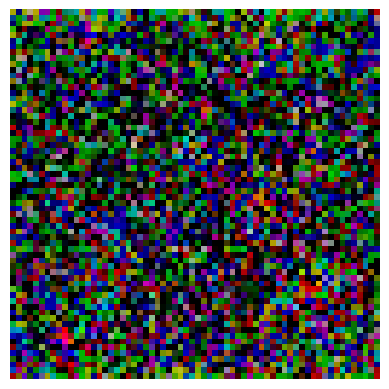

Trigger confidence: 0.03269491717219353


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 2, Source class: 4


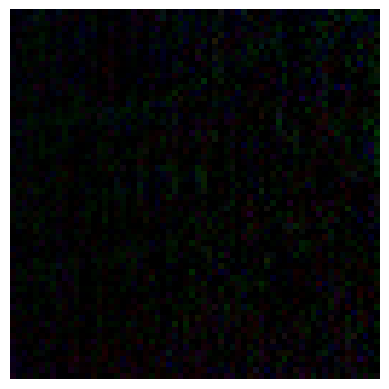

Trigger confidence: 0.10434088855981827


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

Target class: 3, Source class: 1


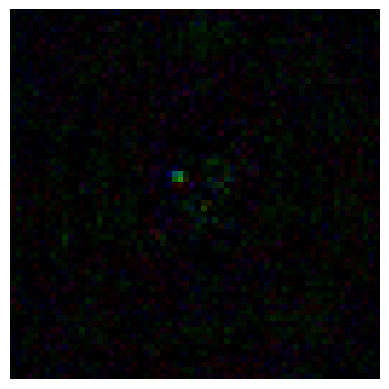

Trigger confidence: 0.4105677902698517


  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Increasing guid_scale


  0%|          | 0/50 [00:00<?, ?it/s]

model_name: cifar10_vit_b_16_trojannn_0_1, predicted_target_class: 0, max_score: 0.27267101407051086, scores: [0.27267101407051086, 0.025458425283432007, 0.1097266748547554, 0.0755646750330925, 0.09453856945037842, 0.04756566882133484, 0.17730830609798431, 0.0829978808760643, 0.09758954495191574, 0.09195223450660706]


Found 10 similarity pairs: [(0, 6, -0.15930834412574768), (1, 0, -0.14546257257461548), (2, 4, -0.13566900789737701), (3, 1, -0.14503353834152222), (4, 3, -0.14497110247612), (5, 0, -0.15470737218856812), (6, 0, -0.15930834412574768), (7, 3, -0.12974879145622253), (8, 3, -0.137338325381279), (9, 3, -0.13469141721725464)]


Augmenting dataset:   0%|          | 0/100 [00:00<?, ?it/s]

guid_scale: 150


  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Trigger generated with confidence 0.9998 for label 0
Evaluation score: 0.4373340606689453


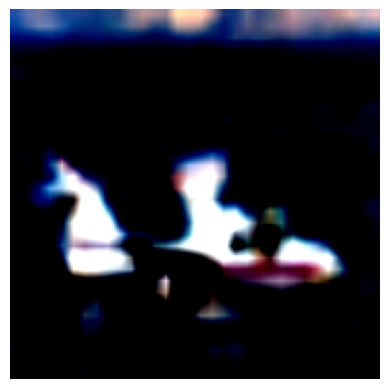

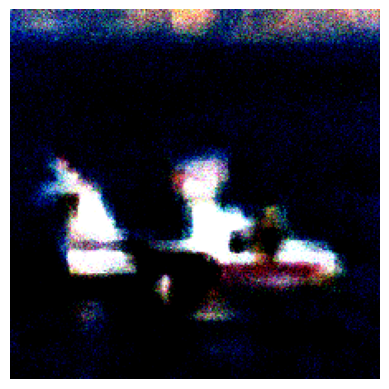

Augmenting dataset:   1%|          | 1/100 [02:39<4:23:44, 159.85s/it]

guid_scale: 150


  0%|          | 0/50 [00:00<?, ?it/s]

Trigger generated with confidence 0.9997 for label 8
Evaluation score: 0.24199113249778748


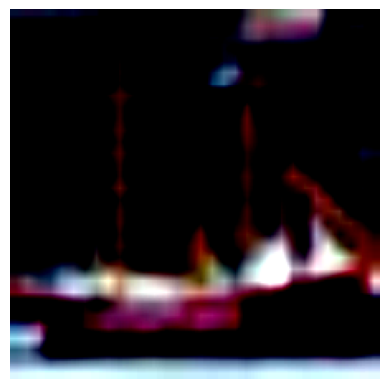

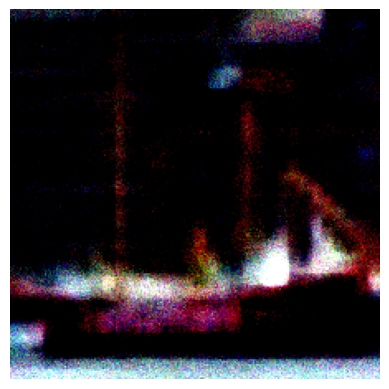

Augmenting dataset:   2%|▏         | 2/100 [02:48<1:56:14, 71.17s/it] 

guid_scale: 150


  0%|          | 0/50 [00:00<?, ?it/s]

guid_scale: 225.0


  0%|          | 0/50 [00:00<?, ?it/s]

Trigger generated with confidence 0.8692 for label 0
Evaluation score: 0.4846407175064087


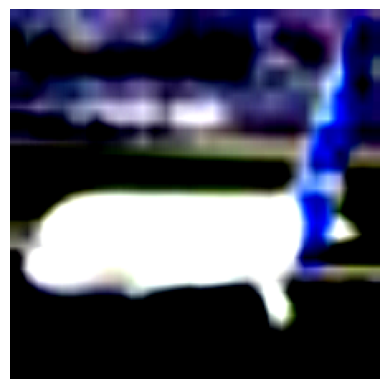

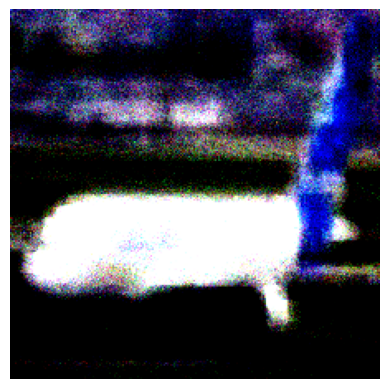

Augmenting dataset:   3%|▎         | 3/100 [03:06<1:15:23, 46.63s/it]

guid_scale: 150


  0%|          | 0/50 [00:00<?, ?it/s]

Trigger generated with confidence 0.9856 for label 9
Evaluation score: 0.4464266896247864


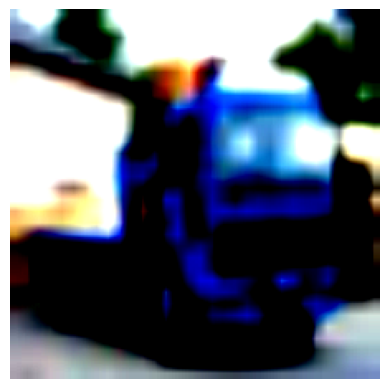

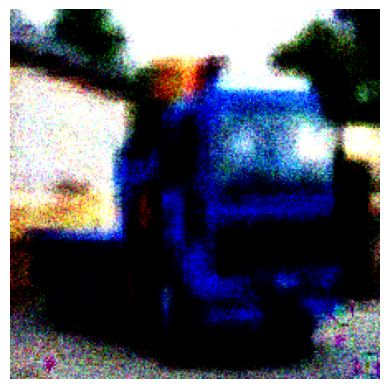

Augmenting dataset:   4%|▍         | 4/100 [03:15<50:53, 31.81s/it]  

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:   5%|▌         | 5/100 [03:24<37:17, 23.56s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:   6%|▌         | 6/100 [03:33<29:06, 18.58s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:   7%|▋         | 7/100 [03:50<28:07, 18.14s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:   8%|▊         | 8/100 [03:59<23:19, 15.21s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:   9%|▉         | 9/100 [04:08<20:05, 13.24s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  10%|█         | 10/100 [04:17<17:52, 11.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  11%|█         | 11/100 [04:26<16:19, 11.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  12%|█▏        | 12/100 [04:43<18:57, 12.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  13%|█▎        | 13/100 [04:52<16:58, 11.71s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  14%|█▍        | 14/100 [05:01<15:34, 10.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  15%|█▌        | 15/100 [05:10<14:34, 10.28s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  16%|█▌        | 16/100 [05:19<13:49,  9.87s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  17%|█▋        | 17/100 [05:28<13:15,  9.59s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  18%|█▊        | 18/100 [05:37<12:49,  9.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  19%|█▉        | 19/100 [05:46<12:29,  9.25s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  20%|██        | 20/100 [05:54<12:11,  9.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  21%|██        | 21/100 [06:03<11:57,  9.09s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  22%|██▏       | 22/100 [06:12<11:45,  9.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  23%|██▎       | 23/100 [06:21<11:33,  9.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  24%|██▍       | 24/100 [06:30<11:23,  8.99s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  25%|██▌       | 25/100 [06:39<11:12,  8.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  26%|██▌       | 26/100 [06:48<11:02,  8.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  27%|██▋       | 27/100 [06:57<10:52,  8.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  28%|██▊       | 28/100 [07:06<10:43,  8.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  29%|██▉       | 29/100 [07:15<10:34,  8.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  30%|███       | 30/100 [07:32<13:20, 11.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  31%|███       | 31/100 [07:41<12:17, 10.68s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  32%|███▏      | 32/100 [07:50<11:30, 10.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  33%|███▎      | 33/100 [07:59<10:55,  9.79s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  34%|███▍      | 34/100 [08:08<10:29,  9.54s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  35%|███▌      | 35/100 [08:17<10:08,  9.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  36%|███▌      | 36/100 [08:26<09:50,  9.23s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  37%|███▋      | 37/100 [08:35<09:35,  9.14s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  38%|███▊      | 38/100 [08:44<09:23,  9.08s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  39%|███▉      | 39/100 [08:52<09:10,  9.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  40%|████      | 40/100 [09:10<11:29, 11.50s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  41%|████      | 41/100 [09:27<13:01, 13.24s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  42%|████▏     | 42/100 [09:36<11:32, 11.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  43%|████▎     | 43/100 [09:53<12:52, 13.55s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  44%|████▍     | 44/100 [10:02<11:20, 12.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  45%|████▌     | 45/100 [10:11<10:15, 11.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  46%|████▌     | 46/100 [10:20<09:27, 10.51s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  47%|████▋     | 47/100 [10:29<08:51, 10.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  48%|████▊     | 48/100 [10:38<08:24,  9.70s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  49%|████▉     | 49/100 [10:47<08:03,  9.47s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  50%|█████     | 50/100 [10:56<07:45,  9.31s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  51%|█████     | 51/100 [11:05<07:30,  9.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  52%|█████▏    | 52/100 [11:14<07:17,  9.11s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  53%|█████▎    | 53/100 [11:22<07:05,  9.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  54%|█████▍    | 54/100 [11:31<06:54,  9.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  55%|█████▌    | 55/100 [11:40<06:44,  8.99s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  56%|█████▌    | 56/100 [11:58<08:25, 11.49s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  57%|█████▋    | 57/100 [12:07<07:41, 10.72s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  58%|█████▊    | 58/100 [12:16<07:07, 10.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  59%|█████▉    | 59/100 [12:24<06:42,  9.81s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  60%|██████    | 60/100 [12:33<06:21,  9.55s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  61%|██████    | 61/100 [12:42<06:05,  9.36s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  62%|██████▏   | 62/100 [12:51<05:51,  9.24s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  63%|██████▎   | 63/100 [13:00<05:39,  9.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  64%|██████▍   | 64/100 [13:09<05:28,  9.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  65%|██████▌   | 65/100 [13:18<05:18,  9.09s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  66%|██████▌   | 66/100 [13:27<05:08,  9.06s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  67%|██████▋   | 67/100 [13:36<04:58,  9.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  68%|██████▊   | 68/100 [13:45<04:48,  9.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  69%|██████▉   | 69/100 [13:54<04:39,  9.01s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  70%|███████   | 70/100 [14:03<04:32,  9.07s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  71%|███████   | 71/100 [14:13<04:22,  9.06s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  72%|███████▏  | 72/100 [14:22<04:13,  9.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  73%|███████▎  | 73/100 [14:31<04:04,  9.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  74%|███████▍  | 74/100 [14:40<03:54,  9.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  75%|███████▌  | 75/100 [14:49<03:45,  9.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  76%|███████▌  | 76/100 [14:58<03:36,  9.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  77%|███████▋  | 77/100 [15:07<03:27,  9.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  78%|███████▊  | 78/100 [15:16<03:18,  9.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  79%|███████▉  | 79/100 [15:25<03:09,  9.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  80%|████████  | 80/100 [15:34<03:00,  9.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  81%|████████  | 81/100 [15:43<02:51,  9.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  82%|████████▏ | 82/100 [15:52<02:42,  9.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  83%|████████▎ | 83/100 [16:01<02:33,  9.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  84%|████████▍ | 84/100 [16:10<02:24,  9.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  85%|████████▌ | 85/100 [16:27<02:53, 11.54s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  86%|████████▌ | 86/100 [16:36<02:30, 10.78s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  87%|████████▋ | 87/100 [16:45<02:13, 10.25s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  88%|████████▊ | 88/100 [16:54<01:58,  9.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  89%|████████▉ | 89/100 [17:03<01:45,  9.62s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  90%|█████████ | 90/100 [17:12<01:34,  9.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  91%|█████████ | 91/100 [17:21<01:23,  9.29s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  92%|█████████▏| 92/100 [17:30<01:13,  9.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  93%|█████████▎| 93/100 [17:39<01:03,  9.13s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  94%|█████████▍| 94/100 [17:48<00:54,  9.08s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  95%|█████████▌| 95/100 [18:06<00:57, 11.57s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  96%|█████████▌| 96/100 [18:15<00:43, 10.79s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  97%|█████████▋| 97/100 [18:24<00:30, 10.25s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  98%|█████████▊| 98/100 [18:33<00:19,  9.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset:  99%|█████████▉| 99/100 [18:41<00:09,  9.58s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

Augmenting dataset: 100%|██████████| 100/100 [18:50<00:00, 11.31s/it]


100%|██████████| 170M/170M [00:04<00:00, 35.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Evaluating before mitigation:


100%|██████████| 282/282 [01:03<00:00,  4.42it/s]


Before mitigation: test_acc: 96.45%, bd_test_asr: 99.98%
Epoch 1/10, Loss: 0.3422
Epoch 2/10, Loss: 0.0736
Epoch 3/10, Loss: 0.0084
Epoch 4/10, Loss: 0.0034
Epoch 5/10, Loss: 0.0023
Epoch 6/10, Loss: 0.0015
Epoch 7/10, Loss: 0.0011
Epoch 8/10, Loss: 0.0009
Epoch 9/10, Loss: 0.0007
Epoch 10/10, Loss: 0.0006


100%|██████████| 282/282 [01:03<00:00,  4.41it/s]

After mitigation: test_acc: 92.32%, bd_test_asr: 5.69%


In [9]:
# Specify the path to your backdoor models
base_path = "../data/vit_cifar10"
backdoor_models = backbench.BackbenchDataset(base_path,model_name='cifar10_vit_b_16_trojannn_0_1')

# Select a specific model to demonstrate the mitigation process
model_index = 0  # You can change this to test different models
model_data = backdoor_models[model_index]
print(f"Selected model: {model_data['model_name']}")

# Run the mitigation process on the selected model
model_name, test_acc, bd_test_asr = mitigate_backdoor_model(
    model_data=model_data,
    model_index=model_index
)

## Results

In [10]:
# Output results
print("\n=== Final Results ===")
print(f"Model: {model_name}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Backdoor Attack Success Rate: {bd_test_asr:.2f}%")

with open(OUTPUT_FILE, "a") as f:
    f.write(f"{model_name} -> bd_test_asr: {bd_test_asr:.2f}%, test_acc: {test_acc*100:.2f}%\n")



=== Final Results ===
Model: cifar10_vit_b_16_trojannn_0_1
Test Accuracy: 92.32%
Backdoor Attack Success Rate: 5.69%
